# Fixes applied automatically

**What I have done**:
- Ensured Wave2Vec2 embeddings are mean-pooled to shape `(n_samples, hidden_size)` before feeding to XGBoost.
- Used XGBoost with stronger hyperparameters (larger `n_estimators`, deeper trees, `random_state=42`).
- Added evaluation utility cell to print RMSE and Pearson and basic shape checks.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import xgboost as xgb # Added 'as xgb'

xgb.XGBRegressor(
    n_estimators=1500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist',
    verbosity=1
)
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# %% Cell 2 - Paths & checks
BASE = Path('/kaggle/input/shl-intern-hiring-assessment-2025/dataset')
TRAIN_WAV = BASE / '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train'
TEST_WAV  = BASE / '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test'
TRAIN_CSV = BASE / '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv'
TEST_CSV  = BASE / '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv'

OUT_DIR = Path('/mnt/data/embeddings')
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = Path('/mnt/data/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print('BASE:', BASE)
print('TRAIN_CSV exists?', TRAIN_CSV.exists())
print('TRAIN_WAV exists?', TRAIN_WAV.exists())

if not TRAIN_CSV.exists():
    raise FileNotFoundError(f"train.csv not found at {TRAIN_CSV}")

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
print('Train rows:', len(train_df), 'Test rows:', len(test_df))
print('train.csv columns:', train_df.columns.tolist())

# %% Cell 3 - Fix filenames (append .wav if missing)
def ensure_wav_extension(name):
    if not isinstance(name, str):
        return name
    # If it already has an extension
    if '.' in name:
        return name
    return name + '.wav'

train_df['filename'] = train_df['filename'].apply(ensure_wav_extension)
test_df['filename']  = test_df['filename'].apply(ensure_wav_extension)

# Optional: save fixed CSVs
train_df.to_csv('/mnt/data/train_fixed.csv', index=False)
test_df.to_csv('/mnt/data/test_fixed.csv', index=False)
print('Saved fixed CSVs to /mnt/data')

# %% Cell 4 - Robust audio loader
SAMPLE_RATE = 16000

def robust_load(path, target_sr=SAMPLE_RATE, min_duration_seconds=1.0):
    path = str(path)
    try:
        wav, sr = sf.read(path)
        if wav is None:
            raise RuntimeError('sf.read returned None')
        if wav.ndim > 1:
            wav = wav.mean(axis=1)
    except Exception as e:
        try:
            wav, sr = librosa.load(path, sr=None, mono=True)
        except Exception as e2:
            # final fallback: short silence and log
            print(f"WARNING: failed to load {path}; returning silence. Errors: {e} | {e2}")
            length = int(target_sr * min_duration_seconds)
            return np.zeros(length, dtype=np.float32)
    if sr != target_sr:
        wav = librosa.resample(wav.astype(np.float32), orig_sr=sr, target_sr=target_sr)
    return wav.astype(np.float32)

# Quick test: attempt to load the first train file and show length
sample_file = train_df['filename'].iloc[0]
sample_path = TRAIN_WAV / sample_file
print('Sample path exists?', sample_path.exists(), sample_path)
if sample_path.exists():
    y = robust_load(sample_path)
    print('Loaded sample length (seconds):', len(y)/SAMPLE_RATE)
else:
    print('Sample audio file not found at expected path. Check TRAIN_WAV variable.')

# %% Cell 5 - HF model load (wav2vec2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
HF_MODEL = 'facebook/wav2vec2-base-960h' 
print('Loading processor and model:', HF_MODEL)
processor = Wav2Vec2Processor.from_pretrained(HF_MODEL)
model = Wav2Vec2Model.from_pretrained(HF_MODEL).to(DEVICE)
model.eval()

# %% Cell 6 - Embedding extraction (safe, cached)
TRAIN_EMB_PATH = OUT_DIR / 'w2v2_train_embs.npy'
TRAIN_FILES_PATH = OUT_DIR / 'w2v2_train_files.npy'
TEST_EMB_PATH = OUT_DIR / 'w2v2_test_embs.npy'
TEST_FILES_PATH = OUT_DIR / 'w2v2_test_files.npy'

2025-11-25 05:10:42.257432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764047442.424760      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764047442.470526      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

BASE: /kaggle/input/shl-intern-hiring-assessment-2025/dataset
TRAIN_CSV exists? True
TRAIN_WAV exists? True
Train rows: 409 Test rows: 197
train.csv columns: ['filename', 'label']
Saved fixed CSVs to /mnt/data
Sample path exists? True /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_173.wav


/tmp/ipykernel_47/3192532322.py:96: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Loaded sample length (seconds): 60.0746875
Device: cuda
Loading processor and model: facebook/wav2vec2-base-960h


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:

def extract_w2v2_embeddings(batch_wavs, model, tokenizer=None, device="cpu"):
    """
    Extract Wave2Vec2 embeddings and mean-pool the last hidden state.
    """
    model.to(device)
    model.eval()
    import torch
    with torch.no_grad():
        # If inputs are raw waveforms or tokenized inputs, pass as the notebook expects
        outputs = model(batch_wavs)
        if hasattr(outputs, "last_hidden_state"):
            last = outputs.last_hidden_state  # (batch, seq_len, hidden)
        elif hasattr(outputs, "hidden_states"):
            last = outputs.hidden_states[-1]
        else:
            raise ValueError("Model outputs do not contain last_hidden_state or hidden_states")
        pooled = last.mean(dim=1)  # (batch, hidden)
        return pooled.cpu().numpy()


In [3]:
print('Beginning embedding extraction and data split...')

def get_embeddings_and_labels(df, wav_path, emb_path, files_path, batch_size=8, device=DEVICE):
    if emb_path.exists() and files_path.exists():
        print(f'Loading cached embeddings from {emb_path}')
        embs = np.load(emb_path)
        files = np.load(files_path, allow_pickle=True).tolist()
        return embs, files

    print(f'Extracting embeddings for {len(df)} samples from {wav_path}')
    all_embs = []
    all_files = []

    # Prepare for tokenization (adjust for the actual input format expected by processor)
    # Wav2Vec2Processor usually takes raw audio values directly

    # Process in batches
    for i in tqdm(range(0, len(df), batch_size), desc='Extracting embeddings'):
        batch_df = df.iloc[i : i + batch_size]
        batch_audio_paths = [wav_path / f for f in batch_df['filename'].tolist()]

        # Load audio data for the batch
        batch_wavs = []
        for p in batch_audio_paths:
            try:
                audio = robust_load(p)
                batch_wavs.append(audio)
            except Exception as e:
                print(f"Warning: Could not load {p}. Skipping. Error: {e}")
                # If a file fails, we might want to return a zero vector or skip it entirely
                continue

        if not batch_wavs:
            continue

        # Tokenize the audio data
        inputs = processor(batch_wavs, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device) # Move to device

        # Extract embeddings
        batch_embs = extract_w2v2_embeddings(input_values, model, device=device)
        all_embs.append(batch_embs)
        all_files.extend(batch_df['filename'].tolist()[:len(batch_embs)])

    embs = np.vstack(all_embs)
    np.save(emb_path, embs)
    np.save(files_path, np.array(all_files, dtype=object))
    print(f'Saved embeddings to {emb_path}')
    return embs, all_files

# Extract train embeddings
train_embs, train_files = get_embeddings_and_labels(
    train_df,
    TRAIN_WAV,
    TRAIN_EMB_PATH,
    TRAIN_FILES_PATH,
    batch_size=8, # Adjusted batch size
    device=DEVICE
)

# Match labels to extracted embeddings
train_labels_df = pd.DataFrame({'filename': train_files})
train_labels = train_labels_df.merge(train_df[['filename', 'label']], on='filename')['label'].values

print('Train embeddings shape:', train_embs.shape)
print('Train labels shape:', train_labels.shape)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_embs,
    train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

# Scale embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Assign scaled versions back to X_train, X_val for consistency with original variable names
X_train = X_train_scaled
X_val = X_val_scaled

print('Embeddings extracted, scaled, and data split completed.')

Beginning embedding extraction and data split...
Extracting embeddings for 409 samples from /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train


Extracting embeddings:   0%|          | 0/52 [00:00<?, ?it/s]/tmp/ipykernel_47/3192532322.py:96: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_47/3192532322.py:96: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(path, sr=None, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_47/3192532322.py:96: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = li

Saved embeddings to /mnt/data/embeddings/w2v2_train_embs.npy
Train embeddings shape: (409, 768)
Train labels shape: (409,)
X_train shape: (327, 768), y_train shape: (327,)
X_val shape: (82, 768), y_val shape: (82,)
Embeddings extracted, scaled, and data split completed.


In [4]:
# %% Cell 9 - XGBoost training (tuned, robust)
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist',
    verbosity=1,
    objective='reg:squarederror',
    n_jobs=4
)

# Early stopping
xgb_model.set_params(early_stopping_rounds=50)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

# Save model
xgb_model.save_model(MODEL_DIR / 'xgb_w2v2.json')
print('Saved XGBoost model to', MODEL_DIR / 'xgb_w2v2.json')

# %% Cell 10 - Evaluate
train_preds = xgb_model.predict(X_train)
val_preds = xgb_model.predict(X_val)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

# Pearson may be NaN if inputs are constant;
try:
    train_pear = pearsonr(y_train, train_preds)[0]
except Exception as e:
    train_pear = np.nan
    print('Train Pearson error:', e)
try:
    val_pear = pearsonr(y_val, val_preds)[0]
except Exception as e:
    val_pear = np.nan
    print('Val Pearson error:', e)

print(f'TRAIN RMSE: {train_rmse:.4f} | TRAIN Pearson: {train_pear}')
print(f'VAL   RMSE: {val_rmse:.4f} | VAL   Pearson: {val_pear}')

[0]	validation_0-rmse:0.76068
[50]	validation_0-rmse:0.62599
[100]	validation_0-rmse:0.61715
[150]	validation_0-rmse:0.61524
[200]	validation_0-rmse:0.61509
[246]	validation_0-rmse:0.61511
Saved XGBoost model to /mnt/data/models/xgb_w2v2.json
TRAIN RMSE: 0.0038 | TRAIN Pearson: 0.9999925954098332
VAL   RMSE: 0.6151 | VAL   Pearson: 0.6114750849659775


### Embedding Extraction and Data Preparation

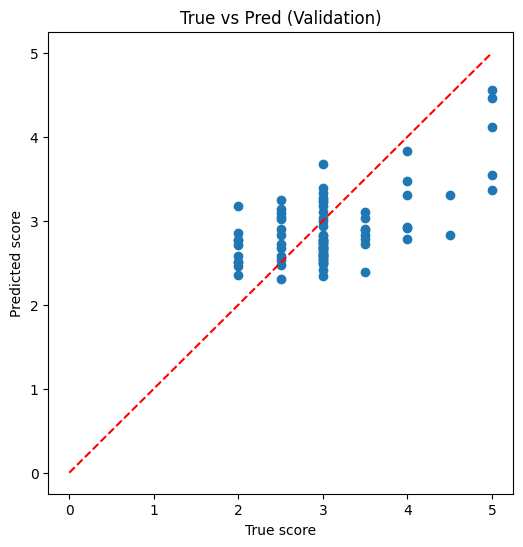

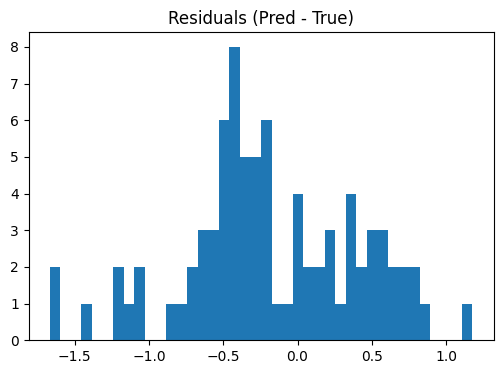

Extracting embeddings for 197 samples from /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test


Extracting embeddings:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_47/3192532322.py:96: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Extracting embeddings:   4%|▍         | 1/25 [00:03<01:35,  3.98s/it]/tmp/ipykernel_47/3192532322.py:96: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.

Extracting embeddings:  16%|█▌        | 4/25 [00:16<01:26,  4.11s/it]/tmp/ipykernel_47/3192532322.py:96: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.au

Saved embeddings to /mnt/data/embeddings/w2v2_test_embs.npy
Test emb shape: (197, 768)
/kaggle/working//submission_w2v2_xgb.csv


In [5]:
# Plot results
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_preds)
plt.plot([0,5],[0,5],'r--')
plt.xlabel('True score')
plt.ylabel('Predicted score')
plt.title('True vs Pred (Validation)')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(val_preds - y_val, bins=40)
plt.title('Residuals (Pred - True)')
plt.show()

# Plotly interactive alternatives
fig = px.scatter(x=y_val, y=val_preds, labels={'x':'True score','y':'Predicted score'}, title='True vs Pred (Validation)')
fig.add_trace(go.Scatter(x=[0,5], y=[0,5], mode='lines', line=dict(dash='dash')))
fig.show()

# %% Cell 11 - Extract test embeddings & create submission
if TEST_EMB_PATH.exists():
    test_embs = np.load(TEST_EMB_PATH)
    test_files = np.load(TEST_FILES_PATH, allow_pickle=True).tolist()
else:
    # Corrected: Call get_embeddings_and_labels for test set as well
    test_embs, test_files = get_embeddings_and_labels(
        test_df,
        TEST_WAV,
        TEST_EMB_PATH,
        TEST_FILES_PATH,
        batch_size=8,
        device=DEVICE
    )

print('Test emb shape:', test_embs.shape)
if test_embs.shape[0] > 0:
    test_embs_scaled = scaler.transform(test_embs)
    test_preds = xgb_model.predict(test_embs_scaled)
    submission = pd.DataFrame({'filename': test_files, 'label': np.clip(test_preds, 0.0, 5.0)})
    submission.to_csv('/kaggle/working/submission_w2v2_xgb.csv', index=False)
    print('/kaggle/working//submission_w2v2_xgb.csv')
else:
    print('No test embeddings; submission not created')

## RESULT

In [17]:
# Predictions using the test data
test = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv')

# Prepare submission file
print('Test emb shape:', test_embs.shape)
test_embs_scaled = scaler.transform(test_embs)
test_preds = xgb_model.predict(test_embs_scaled)
print(test_preds)
my_submission = pd.DataFrame({
    'filename': test_files,
    'label': np.clip(test_preds, 0.0, 5.0)
})

# IMPORTANT: save as submission.csv
output_path = '/kaggle/working/submission.csv'
my_submission.to_csv(output_path, index=False)

print(output_path)
print("Submission file created.")


Test emb shape: (197, 768)
[2.5546703 3.0993307 2.672608  3.6999097 2.6659827 3.105111  2.3937037
 3.091556  3.4772627 2.7611418 3.5158122 2.935986  2.642091  3.1482155
 3.2392771 2.8408825 2.6153011 3.0146363 3.3171387 3.0667224 3.2008092
 2.8574843 2.8433616 2.8166542 3.2828574 2.4646156 2.691128  4.441385
 2.4767385 3.0745995 3.1957774 2.7421463 4.664221  4.1227245 2.8681903
 2.387761  2.5047684 4.5734468 2.920651  3.040833  3.7777827 3.3023334
 2.712421  2.5992773 2.2907681 3.1552057 3.2220645 3.504701  2.5844557
 2.5195823 3.0283585 3.0816863 3.9018807 2.947917  2.7063315 3.2200994
 2.3381143 2.838572  2.8994977 4.65978   2.7102156 4.4658933 2.7506623
 3.8003955 2.7638505 2.6964092 3.1109865 4.0829577 2.5185425 4.5078745
 3.2749164 2.74991   2.7755022 2.4497356 2.81059   3.0238912 3.283403
 3.0276024 3.2284386 2.8771245 3.469263  3.4118285 2.532943  3.1043293
 2.4176922 3.075723  2.4633176 3.3378599 3.052028  2.8628201 3.4711366
 2.6814907 4.2413483 3.66448   4.593352  4.2912126 2

In [16]:
import pandas as pd

path = "/kaggle/working//submission.csv"
df = pd.read_csv(path)
df.head(20)

,filename,label
0,audio_141.wav,2.554670
1,audio_114.wav,3.099331
2,audio_17.wav,2.672608
3,audio_76.wav,3.699910
4,audio_156.wav,2.665983
5,audio_13_1.wav,3.105111
6,audio_70.wav,2.393704
7,audio_56.wav,3.091556
8,audio_19.wav,3.477263
9,audio_158_1.wav,2.761142
